# Task 1

Implement on a quantum simulator of your choice, the following four-qubit state $|\psi(\theta)\rangle$:

![The Variational Circuit](img/Circuit1.jpg)

A combination of one green and one yellow block is called a layer. The number of such layers, denoted by $L$, is considered to be a parameter. If the green variational blocks are called even and the red ones are called odd, then

**Even Blocks**

![An Even Block](img/Circuit3.jpg)

**Odd Blocks**

![An Even Block](img/Circuit2.jpg)

The angles $\theta_{i, n}$ are variational parameters lying in the range $(0, 2\pi)$, initialised at random. The double qubit gates are C-Z gates. 

Report with a plot, as a function of the number of layers $L$, the quantity $$ \varepsilon = \text{min}_\theta || |\psi(\theta)\rangle - |\phi\rangle || $$

called the minimum distance. $|\phi\rangle$ is a randomly generated vector on 4 qubits and $|| \cdot ||$ is the $\mathcal{l}^2$ norm. The right set of parameters $\theta_{i, n}$ can be found via a method of your choice.

In [2]:
#from IPython.display import clear_output

#!pip install qiskit
#clear_output()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.quantum_info import random_statevector
from qiskit.aqua.components.optimizers import ADAM

In [4]:
N = 4 #No of qubits in the system
BACKEND = Aer.get_backend('statevector_simulator')
SHOTS = 500
L = 10 # The maximum number of layers to run the optimiser for

In [5]:
def layer(layer_params: list, **kwargs) -> QuantumCircuit:
    '''
    Creates a layer in the circuit. A layer is defined as
    an odd block and an even block.
    
    Parameters:
        layer_params (list): a list of the parameters theta for the layer
        **num (Optional[int]): Ordinal number for the layer.
    
    Returns:
        layer_circ (QuantumCircuit): a circuit with the layers added.
    '''
    layer_circ = QuantumCircuit(N, name=f'Layer {kwargs["num"]}');
    for i in range(N):
        layer_circ.rx(layer_params[i], i)
    
    for i in range(N):
        layer_circ.rz(layer_params[N+i], i)
        
    for i in range(N):
        for j in range(i, N):
            if(j != i):
                layer_circ.cz(i, j)
    
    return layer_circ

In [6]:
def assemble_circ(params: list) -> QuantumCircuit:
    '''
    Assembles the variational circuit. 
    
    Parameters:
        params (list): A list of theta parameters of the entire circuit.
        
    Returns:
        variational_circ (QuantumCircuit): a circuit with the required
            number of layers.
    '''
    variational_circ = QuantumCircuit(N, name="Variational Circuit")
    
    for num in range(0, len(params), 2*N):
        layer_i = layer(params[num:num+2*N], num=int(num/(2*N) + 1))
        variational_circ.append(layer_i, range(N))
    
    return variational_circ

def run_circ(circ: QuantumCircuit):
    '''
    Executes the circuit on the predefined backend.
    
    Parameters:
        circ (QuantumCircuit): The circuit that is to be run.
    
    Returns:
        measured_state (Statevector): the state obtained after execution of
            the circuit.
    '''
    result = execute(experiments=circ, backend=BACKEND, shots=SHOTS).result()
    measured_state = result.get_statevector()
    
    return measured_state

def rand_circ():
    '''
    Initialises a QuantumCircuit object with a random statevector.
    The random state is used later to define the cost function.
    
    Returns:
        circ (QuantumCircuit): A quantum circuit initialised with a random statevector
    '''
    rand_state = random_statevector(N)
    circ = QuantumCircuit(N, N)
    circ.initialize(rand_state.data, [0, 3])
    
    return circ

#### A Circuit Layer

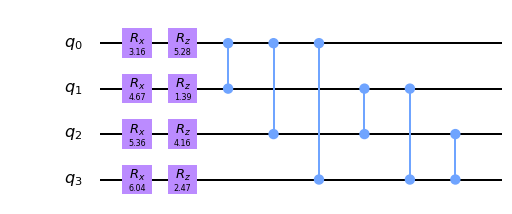

In [7]:
sample_layer = layer(layer_params=[np.random.uniform(0, 2*np.pi) for _ in range(8)], num=1)
sample_layer.draw(output='mpl')

#### An assembled circuit with 3 layers, for example

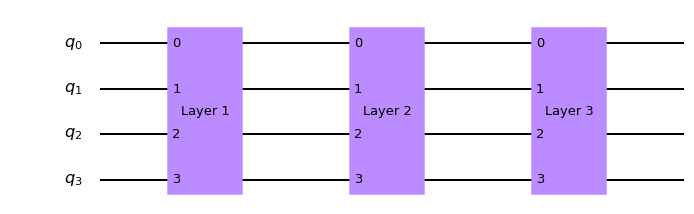

In [8]:
sample_circuit = assemble_circ(params=[np.random.uniform(0, 2*np.pi) for _ in range(8*3)])
sample_circuit.draw(output='mpl')

In [6]:
def state_distance(output_state, target_state) -> float:
    '''
    Defines the "distance" between two states as the l^2 norm of their
        difference.
    
    Parameters:
        output_state (Statevector)
        target_state (Statevector)
    
    Returns:
        state_norm (float): The distance between the two argument states.
    '''
    diff = (output_state - target_state)
    return np.linalg.norm(diff, ord=2)

def cost_function(params: list) -> float:
    '''
    Defines the cost function associated with the problem that is to be
    passed to the optimiser.
    
    Parameters:
        params (list): A list of all parameters (theta values) that
            characterise the circuit
            
    Returns:
        distance (float): the distance between the random state and the state
            measured on the circuit object. 
    '''
    global random_state
    circ = assemble_circ(params)
    measured_state = run_circ(circ=circ)
    distance = state_distance(measured_state, random_state)
    
    return distance

In [7]:
def optimiser(maxiter: int = 1000, 
              tol: float = 0.0002):
    '''
    Defines and initialises the optimiser used. (Adam in this case)
    
    Parameters:
        maxiter (int): Maximum number of iterations
        tol (float): Tolerance for termination
    
    Returns:
        opt (Optimizer): The instantiated Optimiser object.
    
    '''
    return ADAM(maxiter=maxiter, tol=tol)

In [13]:
def run_optimiser() -> list:
    '''
    Runs the optimiser for different number of layers and calculates the 
    minimum distance for each case
    
    Returns:
        A list containing the optimize results. Each result contains three values: point, value and nfev.
               point: is a 1D numpy.ndarray[float] containing the solution
               value: is a float with the objective function value
               nfev: number of objective function calls made if available or None
    '''
    min_distances = []
    
    adam = optimiser()

    for num_layer in range(1, L+1):
        print("Started depth ", num_layer)

        start_time = time.monotonic()
        params = [np.random.uniform(0, 2*np.pi) for _ in range(2*N*num_layer)]

        bounds = []
        for _ in params:
            bounds.append((0, 2*np.pi))

        optimised_result = adam.optimize(num_vars=2*N*num_layer, objective_function=cost_function,
                                           initial_point=params, variable_bounds=bounds)

        min_distances.append(optimised_result)
        end_time = time.monotonic()

        delta_t = timedelta(seconds=end_time - start_time).seconds
        print("Finished depth {} in {} minutes".format(num_layer, (delta_t/60)))
        
    return min_distances

In [9]:
# Initialise the random state
random_state = run_circ(circ=rand_circ())

In [14]:
# Run the optimiser
distances = run_optimiser()

Started depth  1
Finished depth 1 in 2.3666666666666667 minutes
Started depth  2
Finished depth 2 in 5.9 minutes
Started depth  3
Finished depth 3 in 11.016666666666667 minutes
Started depth  4
Finished depth 4 in 17.583333333333332 minutes
Started depth  5
Finished depth 5 in 26.4 minutes
Started depth  6
Finished depth 6 in 35.68333333333333 minutes
Started depth  7
Finished depth 7 in 41.6 minutes
Started depth  8
Finished depth 8 in 36.8 minutes
Started depth  9
Finished depth 9 in 39.916666666666664 minutes
Started depth  10
Finished depth 10 in 83.08333333333333 minutes


Text(0, 0.5, 'Minimum Distance')

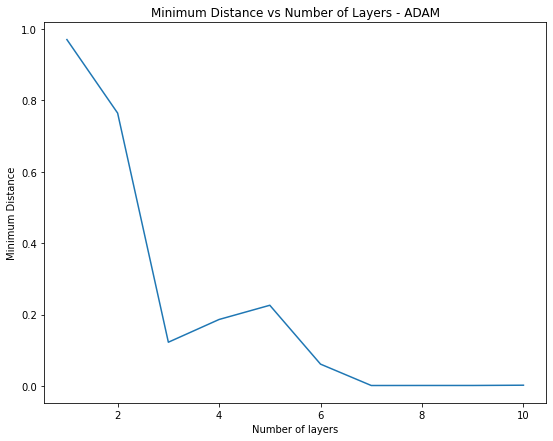

In [16]:
# Plot the variation of minimum distance with circuit depth
x = list(range(1, L+1))
y = [item[1] for item in distances]

plt.figure(figsize=(9, 7))
plt.plot(x, y)
plt.title("Minimum Distance vs Number of Layers - ADAM")
plt.xlabel("Number of layers")
plt.ylabel("Minimum Distance")